In [1]:
import os
os.sys.path.append("C:\\Users\mplitt\MightyMorphingPhotonRangers")
import numpy as np
import matplotlib.pyplot as plt
import utilities as u
import preprocessing as pp
import behavior as b
import SimilarityMatrixAnalysis as sm
import scipy as sp
import PlaceCellAnalysis as pc
import matplotlib.gridspec as gridspec
import pickle
from itertools import product



%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
df = pp.load_session_db()
df = df[df['RewardCount']>30]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
tracks = 'TwoTower_foraging'
df = df[df['Track'].str.contains(tracks,regex=True)]
df= df[df['ImagingRegion'].str.match('CA1')|df['ImagingRegion'].str.match('')]

G:\My Drive\VR_Data\TwoTower\behavior.sqlite
G:\My Drive\VR_Data\TwoTower\4222174.0\30_05_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222168.1\09_08_2019\RuningTraining_1.sqlite
file doesn't exist, errors to come!!!
G:\My Drive\VR_Data\TwoTower\4222169.2\26_08_2019\TwoTower_Timeout_0.sqlite
file doesn't exist, errors to come!!!


In [3]:
morph_rare = ['4139265.3','4139265.4','4139265.5','4222168.1']
morph_familiar = ['4222153.1','4222153.2','4222153.3','4222174.1']


In [4]:
def _get_frac(sess):
    fname = os.path.join("G:\\My Drive\\Figures\\TwoTower\\SingleSession",sess['MouseName'],"TwoTower_foraging_%s_%i" % (sess["DateFolder"],sess["SessionNumber"]),"pc_masks.pkl")
    try:
        with open(fname,'rb') as f:
            res=pickle.load(f)
        masks = res['masks']
    except:
        FR, masks, SI = pc.single_session(sess,win_trial_perm=True,deconv=True)
        with open(fname,'wb') as f:
            pickle.dump({'masks':masks},f)
    return masks[0].sum()/masks[0].shape[0], masks[1].sum()/masks[1].shape[0], (masks[0]*masks[1]).sum()/masks[0].shape[0]
    
    
def _mouse_get_frac(mouse,first_sess=0):
    frac0,frac1,fracc = [],[],[]
    df_mouse = df[df['MouseName'].str.match(mouse)]
    for sess_ind in range(first_sess,df_mouse.shape[0]):
        sess = df_mouse.iloc[sess_ind]
        
        _frac0,_frac1,_fracc = _get_frac(sess)
        frac0.append(_frac0)
        frac1.append(_frac1)
        fracc.append(_fracc)

    return np.array(frac0),np.array(frac1),np.array(fracc)


def frac_list(mouselist,firstSess):
    frac0,frac1,fracc=[],[],[]
    
    if firstSess is None:
        firstSess = len(mlist)*[5]
    elif isinstance(firstSess,int):
        firstSess = len(mlist)*[firstSess]
    else:
        pass
    
    
    for mouse,f_ind in zip(mouselist,firstSess): 
        _frac0,_frac1,_fracc = _mouse_get_frac(mouse,f_ind)
        frac0.append(_frac0)
        frac1.append(_frac1)
        fracc.append(_fracc)
    return frac0, frac1, fracc

rare_frac0,rare_frac1,rare_fracc = frac_list(morph_rare, [5,5,5,3])
fam_frac0, fam_frac1, fam_fracc = frac_list(morph_familiar,[4,4,4,4])
    

# df_mouse = df[df['MouseName'].str.match(mouse)]
# sess = df_mouse.iloc[-1]
# frac0,frac1,fracc = _get_frac(sess)

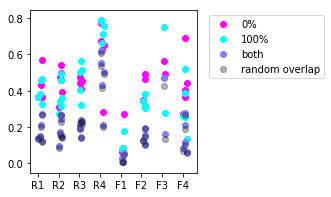

In [5]:
f,ax = plt.subplots(figsize=[3,3])
for i,(f0,f1,frc) in enumerate(zip(rare_frac0 +fam_frac0,rare_frac1 + fam_frac1,rare_fracc+fam_fracc)):
    sessnoise = .2*np.random.uniform(size=f0.shape)
    ax.scatter(i+sessnoise,f0,color=plt.cm.cool(1.),label='0%')
    ax.scatter(i+sessnoise,f1,color=plt.cm.cool(0.),label='100%')
    ax.scatter(i+sessnoise,frc,color=plt.cm.cool(.5),label='both')
    ax.scatter(i+sessnoise,f0*f1,color='black',alpha=.3,label='random overlap')
    if i==0:
        ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
        
ax.set_xticks([0,1,2,3,4,5,6,7])
ax.set_xticklabels(['R1','R2','R3','R4','F1','F2','F3','F4'])
f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures\\PlaceCellFractions.pdf",format='pdf')

In [6]:


def proportion_diff(frac0,frac1,fracc):
    f,ax = plt.subplots(2,2,figsize=[4,8])
    cdiff,diff = [],[]
    for i,(f0,f1,frc) in enumerate(zip(frac0 ,frac1,fracc)):
        arr= np.concatenate((f0[:,np.newaxis],f1[:,np.newaxis]),axis=1)
        arrc = np.concatenate((frc[:,np.newaxis],(f0*f1)[:,np.newaxis]),axis=1)

        ax[0,0].plot([0,1],arr.T,color='black')
        ax[0,1].plot([0,1],arrc.T,color='black')
        
        cdiff.extend((arrc[:,0]-arrc[:,1]).tolist())
        diff.extend((f0-f1).tolist())
    
    ax[1,0].hist(diff)
    ax[1,1].hist(cdiff)
    
    stat,p = sp.stats.ttest_rel(arr[:,0],arr[:,1])
    print('frac diff',p,stat,np.median(diff))
    cstat,cp = sp.stats.ttest_rel(arrc[:,0],arrc[:,1])
    print('common diff',cp,cstat,np.median(cdiff))
    
    return f,ax
    




frac diff 0.1376149410341186 -1.852345837767056 -0.0011007154650523043
common diff 0.005081423466637269 5.572640629840875 0.008664846320801
frac diff 0.23620916792667526 1.3924150679978475 0.052458578948645154
common diff 0.014476326147019944 4.131491151809298 0.011263121638500392


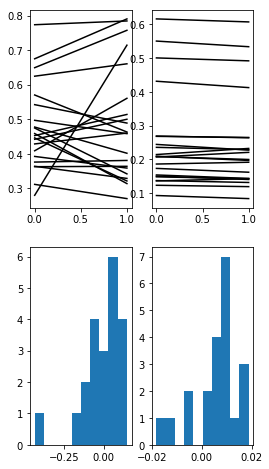

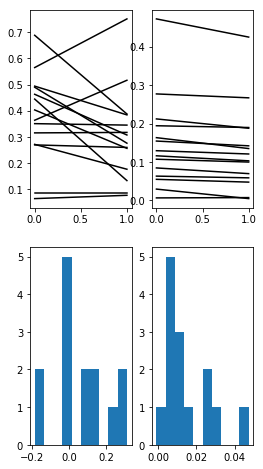

In [7]:
f,ax = proportion_diff(rare_frac0,rare_frac1,rare_fracc)
f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures\\FracDiffRare.pdf",format='pdf')
f,ax = proportion_diff(fam_frac0,fam_frac1,fam_fracc)
f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures\\FracDiffFam.pdf",format='pdf')

In [56]:
.01*1500

15.0

(3, 2)
(4, 2)
(2, 2)
(5, 2)


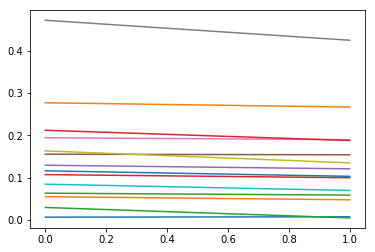

In [40]:
f,ax = plt.subplots()
for i,(f0,f1,frc) in enumerate(zip(fam_frac0 ,fam_frac1,fam_fracc)):
    arr = np.concatenate((frc[:,np.newaxis],(f0*f1)[:,np.newaxis]),axis=1)
    print(arr.shape)
    ax.plot([0,1],arr.T)

(0, 0)
(0, 1)
(1, 0)
(1, 1)


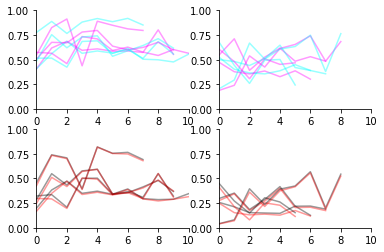

In [6]:
# f,ax = plt.subplots(2,2)

# for (fr0,fr1,frc) in zip(rare_frac0,rare_frac1,rare_fracc):
#     ax[0,0].plot(fr0,color=plt.cm.cool(1.),alpha=.4)
#     ax[0,0].plot(fr1,color=plt.cm.cool(0.),alpha=.4)
#     ax[1,0].plot(frc,color='black',alpha=.4)
#     ax[1,0].plot(fr0*fr1,color='red',alpha=.4)



# for (fr0,fr1,frc) in zip(fam_frac0,fam_frac1,fam_fracc):
#     ax[0,1].plot(fr0,color=plt.cm.cool(1.),alpha=.4)
#     ax[0,1].plot(fr1,color=plt.cm.cool(0.),alpha=.4)
#     ax[1,1].plot(frc,color='black',alpha=.4)
#     ax[1,1].plot(fr0*fr1,color='red',alpha=.4)

# for p in product([0,1],[0,1]):
#     print(p)
#     ax[p].set_xlim([0,10])
#     ax[p].set_ylim([0,1.])
#     ax[p].spines['top'].set_visible(False)
#     ax[p].spines['right'].set_visible(False)

In [8]:
f.savefig("G:\\My Drive\\manuscripts\\MightyMorphinPhotonRangers_manuscript\\Figures\\PlaceCellFractions.pdf",format='pdf')